<a href="https://colab.research.google.com/github/romanfen/F21DL-G6/blob/main/Lab_10_MultiLayer_Perceptron_Heart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [73]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# perceptron set up
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

# stratificiation set up
from sklearn.model_selection import StratifiedShuffleSplit

# test imports
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

# Load Data

Chosen dataset relates to data from patients to deduce their risk of heart attack.

Source: https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

Columns:
* Age: Age of patient (numerical)
* Sex: Sex of patient (ordinal)
```
0 : Female
1 : Male
```
* Cp: Chest Pain type (ordinal)
```
0 : typical angina
1 : atypical angina
2 : non-anginal 
3 : asymptomatic
```
* Trtbps: Resting blood pressure measured in mm Hg (numerical)
* Chol: Cholesterol in mg/dl via BMI sensor (numerical)
* Fbs: Is fasting blood sugar below 120 mg / dl (binary)
```
0 : False
1 : True
```
* Rest_ecg Resting Electrocardiographic Results (ordinal)
```
0 : Normal
1 : ST-T Wave Abnormality
2 : Probably / definite ventricular hypertrophy
```
* Thalach: Maximum heart rate achieved (numerical)
* Exang: Does patient experience exercise induced angina (binary)
```
0 : No
1 : Yes
```
* Oldpeak: ST depression induced by exercise relative to rest (numerical)
* Slp: Slope of peak exercise ST segment (ordinal)
```
0 : unsloping
1 : flat
2 : downsloping
```
* caa: Number of major blood vessels (numerical range from 0 to 3)
* thall: thalassemia
```
0 : null
1 : fixed defect
2 : normal 
3 : reversable defect
```

Target:
* output: Diagnosis Chance of Heart Disease
```
0 : Less Chance
1 : Increased Risk
```

In [18]:
# Load the data
def load_data():
    url = "https://raw.githubusercontent.com/romanfen/F21DL-G6/main/datasets/heart.csv"
    return pd.read_csv(url)

heart_data = load_data()
heart_cols = list(heart_data.columns)
print(heart_cols)

['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output']


Split into 3 sets of data

In [28]:
def split_dataset(data, ratio):
  split = StratifiedShuffleSplit(n_splits=1, test_size=ratio, random_state=42)
  for train_index, test_index in split.split(data, data["output"]):
      strat_train_set = data.loc[train_index]
      strat_test_set = data.loc[test_index]
  return strat_train_set, strat_test_set

Set A - 80/20 split of training set and testing set

In [39]:
A_train, A_test = split_dataset(heart_data, 0.2)

Set B - 56/44 split of training set and testing set, moved 30% of training examples to the testing examples

---



In [40]:
B_train, B_test = split_dataset(heart_data, 0.44)

Set C - 32/68 split of training and testing set, moved 60% from original training set to testing set

In [41]:
C_train, C_test = split_dataset(heart_data, 0.68)

# Perceptron

In [52]:
def fit_data(data, i, t):
  x = data.iloc[:, :-1]
  y = data.iloc[:, -1]
  clf = Perceptron(max_iter=i, tol=t)
  clf.fit(x,y)
  return clf, x, y

Fitting the classifier with the training set A and then predicting for someone with healthy results gives a result which classifies them as being low risk for heart disease.

In [53]:
per_clf_A, X, y = fit_data(A_train, 1000, 1e-3)

pred = per_clf_A.predict([[22, 1, 2, 110, 180, 1, 0, 100, 0, 0.5, 0, 1, 0]])
pred

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Perceptron was fitted with feature names
  "X does not have valid feature names, but"


array([0])

In [60]:
per_clf_B, Xb, yb = fit_data(B_train, 1000, 1e-3)
per_clf_C, Xc, yc = fit_data(C_train, 1000, 1e-3)

Test the perceptron for the test datasets

In [61]:
per_clf_A.score(A_test.iloc[:, :-1], A_test.iloc[:, -1])

0.6885245901639344

In [62]:
per_clf_B.score(B_test.iloc[:, :-1], B_test.iloc[:, -1])

0.6417910447761194

In [63]:
per_clf_C.score(C_test.iloc[:, :-1], C_test.iloc[:, -1])

0.45893719806763283

# Accuracy Tests

Classifier | Accuracy | TP | FP | FN | TN | Sensitivity |Specificity | Precision | Recall | F1 Score | ROC Area
-----------|-------|---|--|--|--|-------|-------|-------|-------|-------|------
A |0.59048|17|11|19|14|0.54939|0.633333|0.59016|0.59016|0.59016|0.78
B |0.60330|43|18|38|35|0.55128|0.67857|0.60448|0.60448|0.60448|0.76
C |0.58024|33|61|87|16|0.55932|0.58783|0.57971|0.57971|0.57971|0.70


In [57]:
def testModel(model, test_data, predict):
  train_pred = cross_val_predict(model, test_data, predict, cv=10)
  cM = confusion_matrix(predict, train_pred)
  TPos, FPos, TNeg, FNeg = cM[0][0] , cM[0][1] , cM[1][0] , cM[1][1]
  print("Accuracy :" , np.mean(cross_val_score(model, test_data, predict, cv=10, scoring="accuracy")))
  print("Confusion Matrix: " , cM)
  print("True Positives: " , TPos)
  print("False Positives: " , FPos)
  print("False Negatives: " , FNeg)
  print("True Negatives: " , TNeg)
  print("Sensitivity: " , cM[0][0] / (cM[0][0]+cM[1][0]))
  print("Specificity: " , cM[1][1] / (cM[1][1]+cM[0][1]))
  print("Precision: ", precision_score(predict, train_pred, average='micro'))
  print("Recall: " , recall_score(predict, train_pred, average='micro'))
  print("F1 Score: " , f1_score(predict, train_pred, average='micro'))

Test Model A

Accuracy : 0.5904761904761904
Confusion Matrix:  [[17 11]
 [14 19]]
True Positives:  17
False Positives:  11
False Negatives:  19
True Negatives:  14
Sensitivity:  0.5483870967741935
Specificity:  0.6333333333333333
Precision:  0.5901639344262295
Recall:  0.5901639344262295
F1 Score:  0.5901639344262295


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


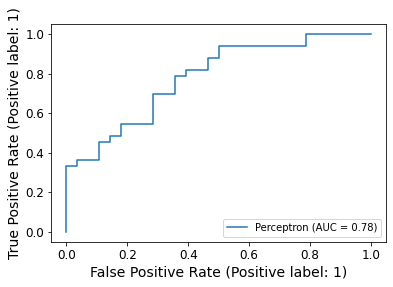

In [74]:
testModel(per_clf_A, A_test.iloc[:, :-1], A_test.iloc[:, -1])
plot_roc_curve(per_clf_A, A_test.iloc[:, :-1], A_test.iloc[:, -1])

Test Model B

Accuracy : 0.6032967032967034
Confusion Matrix:  [[43 18]
 [35 38]]
True Positives:  43
False Positives:  18
False Negatives:  38
True Negatives:  35
Sensitivity:  0.5512820512820513
Specificity:  0.6785714285714286
Precision:  0.6044776119402985
Recall:  0.6044776119402985
F1 Score:  0.6044776119402985


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


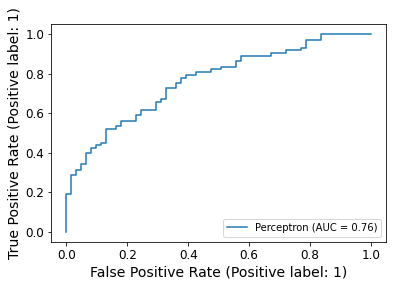

In [75]:
testModel(per_clf_B, B_test.iloc[:, :-1], B_test.iloc[:, -1])
plot_roc_curve(per_clf_B, B_test.iloc[:, :-1], B_test.iloc[:, -1])

Test Model C

Accuracy : 0.5802380952380953
Confusion Matrix:  [[33 61]
 [26 87]]
True Positives:  33
False Positives:  61
False Negatives:  87
True Negatives:  26
Sensitivity:  0.559322033898305
Specificity:  0.5878378378378378
Precision:  0.5797101449275363
Recall:  0.5797101449275363
F1 Score:  0.5797101449275363


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


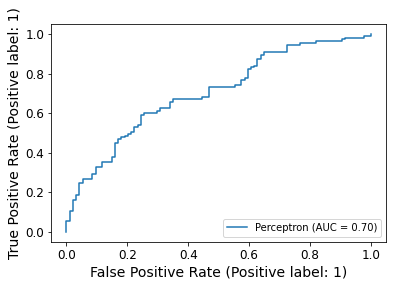

In [76]:
testModel(per_clf_C, C_test.iloc[:, :-1], C_test.iloc[:, -1])
plot_roc_curve(per_clf_C, C_test.iloc[:, :-1], C_test.iloc[:, -1])